<a href="https://colab.research.google.com/github/nalgo-intern/team-a/blob/master/sample_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1Riht24nHdRUCWrjUtaJJD-v2-Rbawe_C'})

downloaded.GetContentFile('train.zip')

In [0]:
downloaded = drive.CreateFile({'id':'1ky7H7UJOw-em387oTDbmCcQXhQPlVGUG'})

downloaded.GetContentFile('validation.zip')

In [77]:
!unzip train.zip
!unzip validation.zip

Archive:  train.zip
replace train/chimpanzee/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/chimpanzee/000001.jpg  
  inflating: train/chimpanzee/000002.jpg  
  inflating: train/chimpanzee/000003.jpg  
  inflating: train/chimpanzee/000006.jpg  
  inflating: train/chimpanzee/000007.jpg  
  inflating: train/chimpanzee/000009.jpg  
  inflating: train/chimpanzee/000010.jpg  
  inflating: train/chimpanzee/000011.jpg  
  inflating: train/chimpanzee/000012.jpg  
  inflating: train/chimpanzee/000013.jpg  
  inflating: train/chimpanzee/000014.jpg  
  inflating: train/chimpanzee/000015.jpg  
  inflating: train/chimpanzee/000016.jpg  
  inflating: train/chimpanzee/000017.jpg  
  inflating: train/chimpanzee/000019.jpg  
  inflating: train/chimpanzee/000020.jpg  
  inflating: train/chimpanzee/000021.jpg  
  inflating: train/chimpanzee/000022.jpg  
  inflating: train/chimpanzee/000023.png  
  inflating: train/chimpanzee/000024.jpg  
  inflating: train/chimpanzee/000025.JPG  


In [85]:
from keras.models import Model
from keras.layers import Dense,Input,GlobalMaxPooling2D,Dropout
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

N_CATEGORIES = 3
IMAGE_SIZE = 224
BATCH_SIZE = 8

NUM_TRAINING = 288
NUM_VALIDATION = 72

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor)

x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(.25)(x)
x = Dense(1024, activation='relu')(x)


predictions = Dense(N_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[:15]:
   layer.trainable = False

model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

json_string=model.to_json()
open("model"+'.json','w').write(json_string)

train_datagen = ImageDataGenerator(
   rescale=1.0 / 255,
   shear_range=0,
   zoom_range=0.1,
   horizontal_flip=True,
   rotation_range=0)

test_datagen = ImageDataGenerator(
   rescale=1.0 / 255,
)
train_generator = train_datagen.flow_from_directory(
   'train',
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
   'validation',
   target_size=(IMAGE_SIZE, IMAGE_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   shuffle=True
)

hist = model.fit_generator(train_generator,
   steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
   epochs=40,
   verbose=1,
   validation_data=validation_generator,
   validation_steps=NUM_VALIDATION//BATCH_SIZE,
   )

model.save('monkey.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
upload_file_2 = drive.CreateFile()
upload_file_2.SetContentFile("monkey.hdf5")
upload_file_2.Upload()

In [0]:
from google.colab import files
files.download('model.json')

In [0]:
downloaded = drive.CreateFile({'id':'1zENdcODgWa-Wyltz1v62D3gN_6NXFP8A'})

downloaded.GetContentFile('test3.zip')

In [65]:
!unzip test3.zip

Archive:  test3.zip
  inflating: test3/gorilla.jpg       
replace test3/haranishi.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test3/haranishi.jpg     
  inflating: test3/haranishi2.jpg    
  inflating: test3/image.jpg         


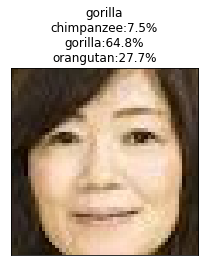

chimpanzee
0.07536933
gorilla
0.6476976
orangutan
0.27693304


In [98]:
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D,Input,Dropout
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os,random
import sys
from keras.preprocessing.image import img_to_array, load_img

file_name='monkey'
display_dir='test3'
label=['chimpanzee','gorilla','orangutan']

N_CATEGORIES  = 3
IMAGE_SIZE = 224
BATCH_SIZE = 8
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor)
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(.25)(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(N_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.load_weights(file_name+'.hdf5')

model.compile(optimizer=SGD(lr=1e-4,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


files=os.listdir(display_dir)




# 画像の読み込み
image_gs = cv2.imread("test3/haranishi.jpg")

# 顔認識用特徴量ファイルを読み込む --- （カスケードファイルのパスを指定）
cascade = cv2.CascadeClassifier("./haarcascade_frontalface_alt.xml")
#判定！
face = cascade.detectMultiScale(image_gs)



if face.all():
  
    for x,y,w,h in face:
        face_cut = image_gs[y:y+h, x:x+w]
    #切り抜き保存！    
    cv2.imwrite('test3/face_cut.jpg', face_cut)

else:
    
    
    #そのまま保存
    cv2.imwrite('test3/face_cut.jpg', image_gs)
    
plt.figure(figsize=(20,20))
for i in range(1):
    temp_img=load_img(os.path.join(display_dir,"haranishi.jpg"),target_size=(224,224))
    temp_img_cut=load_img(os.path.join(display_dir,"face_cut.jpg"),target_size=(224,224))
    
    plt.subplot(5,5,i+1)
    plt.imshow(temp_img_cut)
    
    temp_img_array=img_to_array(temp_img_cut)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    
    img_pred=model.predict(temp_img_array)
    a=Decimal(str(img_pred[0][0]*100)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
    b=Decimal(str(img_pred[0][1]*100)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
    c=Decimal(str(img_pred[0][2]*100)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
    plt.title(label[np.argmax(img_pred)]+'\n'+label[0]+':'+str(a)+'%'+'\n'+label[1]+':'+str(b)+'%'+'\n'+label[2]+':'+str(c)+'%')
    
    plt.xticks([]),plt.yticks([])

plt.show()
for j in range(3):
    print (label[j])
    print (img_pred[0][j])